#### Importando as bibliotecas úteis, tais como classificadores etc...

In [68]:
import pandas as pd
import pprint
import matplotlib.pyplot as plt
import math
import operator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, precision_score


# ignore warnings
import warnings
warnings.filterwarnings('ignore')


#### Lendo o Dataset e mostrando as primeiras linhas

In [69]:
dataset = pd.read_csv("diagnosed_cbc_data_v4.csv")
dataset.head()

,WBC,LYMp,NEUTp,LYMn,NEUTn,RBC,HGB,HCT,MCV,MCH,MCHC,PLT,PDW,PCT,Diagnosis
0,10.0,43.2,50.1,4.3,5.0,2.77,7.3,24.2,87.7,26.3,30.1,189.0,12.5,0.17,Normocytic hypochromic anemia
1,10.0,42.4,52.3,4.2,5.3,2.84,7.3,25.0,88.2,25.7,20.2,180.0,12.5,0.16,Normocytic hypochromic anemia
2,7.2,30.7,60.7,2.2,4.4,3.97,9.0,30.5,77.0,22.6,29.5,148.0,14.3,0.14,Iron deficiency anemia
3,6.0,30.2,63.5,1.8,3.8,4.22,3.8,32.8,77.9,23.2,29.8,143.0,11.3,0.12,Iron deficiency anemia
4,4.2,39.1,53.7,1.6,2.3,3.93,0.4,316.0,80.6,23.9,29.7,236.0,12.8,0.22,Normocytic hypochromic anemia


#### Características do Dataset
- HGB: The amount of hemoglobin in the blood, crucial for oxygen transport.

- PlT: The number of platelets in the blood, involved in blood clotting.

- WBC: The count of white blood cells, vital for immune response.

- RBC: The count of red blood cells, responsible for oxygen transport.

- MCV (Mean Corpuscular Volume): Average volume of a single red blood cell.

- MCH (Mean Corpuscular Hemoglobin): Average amount of hemoglobin per red blood cell.

- MCHC (Mean Corpuscular Hemoglobin Concentration): Average concentration of hemoglobin in red blood cells.

- PDW: a measurement of the variability in platelet size distribution in the blood

- PCT: A procalcitonin test can help your health care provider diagnose if you have sepsis from a bacterial infection or if you have a high risk of developing sepsis

- LYMp: Percentage of lymphocytes

- NEUTp: Percentage of neutrophils

- LYMn: Absolute lymphocyte count

- NEUTn: Absolute neutrophil count

- Diagnosis: Anemia type based on the CBC parameters

#### Etapa de pré-processamento da Base de Dados

Visualizando a quantidade de dados e quantidade de colunas

In [70]:
dataset.shape

(1281, 15)

Verificando as classes e a quantidade de classes únicas

In [71]:
unique_targets = set(dataset['Diagnosis'])
pprint.pprint(unique_targets)
print("Quantidade de classes únicas -> ", len(unique_targets))

{'Healthy',
 'Iron deficiency anemia',
 'Leukemia',
 'Leukemia with thrombocytopenia',
 'Macrocytic anemia',
 'Normocytic hypochromic anemia',
 'Normocytic normochromic anemia',
 'Other microcytic anemia',
 'Thrombocytopenia'}
Quantidade de classes únicas ->  9


Verificando se há valores nulos

In [72]:
dataset.isnull().sum()

WBC          0
LYMp         0
NEUTp        0
LYMn         0
NEUTn        0
RBC          0
HGB          0
HCT          0
MCV          0
MCH          0
MCHC         0
PLT          0
PDW          0
PCT          0
Diagnosis    0
dtype: int64

Verificando se alguma coluna possui valores negativos

In [73]:
for col in dataset.columns:
    try:
        if dataset[col].min() < 0:
            print(col)
    except:
        pass

HGB
MCV


Excluíndo linhas com valores negativos

In [74]:
dataset= dataset.drop(dataset[dataset['HGB'] < 0].index[0])
dataset = dataset.drop(dataset[dataset['MCV'] < 0].index[0])

Checkando duplicações e realizando exclusões, caso haja

In [75]:
print("Duplicações antes da exclusão: ", dataset.duplicated().sum())
dataset.drop_duplicates(inplace=True)
print("Duplicações após exclusão: ", dataset.duplicated().sum())

Duplicações antes da exclusão:  49
Duplicações após exclusão:  0


In [76]:
# replace class values with integers
for i, target in enumerate(unique_targets):
    dataset['Diagnosis'] = dataset['Diagnosis'].replace(target, i)
dataset['Diagnosis']

0       0
1       0
2       4
3       4
4       0
       ..
1276    5
1277    5
1278    5
1279    5
1280    5
Name: Diagnosis, Length: 1230, dtype: int64

#### Separando as variáveis X e Y (target)

In [77]:
y = dataset['Diagnosis']
x = dataset.drop('Diagnosis', axis=1)
# y = y.values

In [78]:
def euclidean_distance(value_1, value_2, length):
    distance = 0
    for index in range(length):
        distance += pow((value_1[index] - value_2[index]), 2)
    return math.sqrt(distance)

In [79]:
def KNeighbors(x_train, x_test, k):
    distances = []
    index = 0
    for _, row in x_train.iterrows():
        dist = euclidean_distance(x_test, row, len(x_test))
        distances.append((index, dist))
        index+=1
    
    distances.sort(key=operator.itemgetter(1))
    neighbors = []
    for x in range(k):
        neighbors.append(distances[x][0])
    return neighbors


In [80]:
def predict(neighbors, y_train):
    class_predicts = {}
    for neighbor_index in neighbors:
        response = y_train[neighbor_index]
        if response in class_predicts:
            class_predicts[response] += 1
        else:
            class_predicts[response] = 1

    predictions = sorted(class_predicts.items(), key=operator.itemgetter(1), reverse=True)
    return predictions[0][0]



In [81]:
def confusion_matrix_and_accuracy(y_true, y_pred):
    classes = sorted(set(y_true))
    matrix = {cls: {cls_inner: 0 for cls_inner in classes} for cls in classes}
    correct_predictions = 0

    for true, pred in zip(y_true, y_pred):
        matrix[true][pred] += 1
        if true == pred:
            correct_predictions += 1

    accuracy = correct_predictions / len(y_true)
    return matrix, accuracy

In [82]:
kf =KFold(n_splits=5, shuffle=True, random_state=42)
overall_y_true = []
overall_y_pred = []

accuracy_list = []
f1_list = []
recall_list = []
precision_list = []

for train_index, test_index in kf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
  
    y_true = []
    y_pred = []
    for _, row in x_test.iterrows():
        neighbors = KNeighbors(x_train, row, 5)
        result = predict(neighbors, y_train.values)
        y_pred.append(result)
    
    y_true.extend(y_test)
    overall_y_true.extend(y_true)
    overall_y_pred.extend(y_pred)

    accuracy_list.append(accuracy_score(y_true, y_pred))
    f1_list.append(f1_score(y_true, y_pred, average='weighted'))
    recall_list.append(recall_score(y_true, y_pred, average='weighted'))
    precision_list.append(precision_score(y_true, y_pred, average='weighted'))

print("Acurácia %0.2f (+/- %0.2f)" % (np.mean(accuracy_list), np.std(accuracy_list) * 2))
print("F1 %0.2f (+/- %0.2f)" % (np.mean(f1_list), np.std(f1_list) * 2))
print("Recall %0.2f (+/- %0.2f)" % (np.mean(recall_list), np.std(recall_list) * 2))
print("Precision %0.2f (+/- %0.2f)" % (np.mean(precision_list), np.std(precision_list) * 2))



Acurácia 0.67 (+/- 0.06)
F1 0.66 (+/- 0.06)
Recall 0.67 (+/- 0.06)
Precision 0.67 (+/- 0.07)


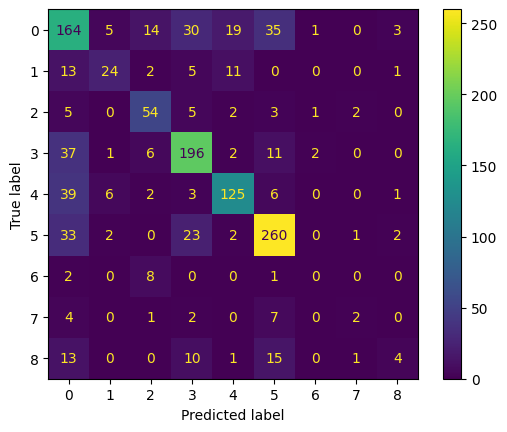

In [83]:
confusion_matrix = metrics.confusion_matrix(overall_y_true, overall_y_pred)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [i for i in range(len(unique_targets))])
cm_display.plot()
plt.show()

#### Referências

- https://www.kaggle.com/datasets/ehababoelnaga/anemia-types-classification/data

- https://www.appsilon.com/post/machine-learning-evaluation-metrics-classification

- https://towardsdatascience.com/building-a-k-nearest-neighbors-k-nn-model-with-scikit-learn-51209555453a

- https://stackoverflow.com/questions/73893276/how-to-apply-the-result-of-k-fold-cross-validation-on-my-original-test-set

- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold

- https://www.w3schools.com/python/python_ml_confusion_matrix.asp